<a href="https://colab.research.google.com/github/HabilMB/movie-score-prediction-model/blob/main/Movie_Review_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##setup dependencies

In [ ]:
import ast
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import numpy as np
from keras.layers import SimpleRNN


import pandas as pd
from collections import Counter
import re

In [ ]:
#GET kaggle.json FROM YOUR ACCOUNT
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"habilmediobhakti","key":"c74390766cf8334a984cd192383c4532"}'}

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!kaggle datasets download -d utsh0dey/25k-movie-dataset

 64% 3.00M/4.67M [00:00<00:00, 5.56MB/s]
100% 4.67M/4.67M [00:00<00:00, 6.78MB/s]


In [ ]:
!unzip "/content/25k-movie-dataset" -d "/content/kaggle/"

Archive:  /content/25k-movie-dataset.zip
  inflating: /content/kaggle/25k IMDb movie Dataset.csv  


In [ ]:
df_credits = pd.read_csv('/content/kaggle/25k IMDb movie Dataset.csv')
df_credits.head(10)

,movie title,Run Time,Rating,User Rating,Generes,Overview,Plot Kyeword,Director,Top 5 Casts,Writer,year,path
0,Top Gun: Maverick,"$170,000,000 (estimated)",8.6,187K,"['Action', 'Drama']",After more than thirty years of service as one...,"['fighter jet', 'sequel', 'u.s. navy', 'fighte...",Joseph Kosinski,"['Jack Epps Jr.', 'Peter Craig', 'Tom Cruise',...",Jim Cash,-2022,/title/tt1745960/
1,Jurassic World Dominion,2 hours 27 minutes,6,56K,"['Action', 'Adventure', 'Sci-Fi']",Four years after the destruction of Isla Nubla...,"['dinosaur', 'jurassic park', 'tyrannosaurus r...",Colin Trevorrow,"['Colin Trevorrow', 'Derek Connolly', 'Chris P...",Emily Carmichael,-2022,/title/tt8041270/
2,Top Gun,"$15,000,000 (estimated)",6.9,380K,"['Action', 'Drama']",As students at the United States Navy's elite ...,"['pilot', 'male camaraderie', 'u.s. navy', 'gr...",Tony Scott,"['Jack Epps Jr.', 'Ehud Yonay', 'Tom Cruise', ...",Jim Cash,-1986,/title/tt0092099/
3,Lightyear,"$71,101,257",5.2,32K,"['Animation', 'Action', 'Adventure']",While spending years attempting to return home...,"['galaxy', 'spaceship', 'robot', 'rocket', 'sp...",Angus MacLane,"['Jason Headley', 'Matthew Aldrich', 'Chris Ev...",Angus MacLane,-2022,/title/tt10298810/
4,Spiderhead,not-released,5.4,23K,"['Action', 'Crime', 'Drama']","In the near future, convicts are offered the c...","['discover', 'medical', 'test', 'reality', 'fi...",Joseph Kosinski,"['Rhett Reese', 'Paul Wernick', 'Chris Hemswor...",George Saunders,-2022,/title/tt9783600/
5,Everything Everywhere All at Once,2 hours 19 minutes,8.3,124K,"['Action', 'Adventure', 'Comedy']",An aging Chinese immigrant is swept up in an i...,"['multiverse', 'saving the world', 'mother dau...",Dan Kwan,"['Dan Kwan', 'Daniel Scheinert', 'Michelle Yeo...",Daniel Scheinert,-2022,/title/tt6710474/
6,Interceptor,not-released,4.4,17K,"['Action', 'Adventure', 'Drama']",One Army captain must use her years of tactica...,"['violence', 'gun', 'handgun', 'gun fight', 'o...",Matthew Reilly,"['Stuart Beattie', 'Elsa Pataky', 'Luke Bracey...",Matthew Reilly,-2022,/title/tt14174940/
7,Interceptor,1 hour 30 minutes,3.6,819,"['Action', 'Sci-Fi', 'Thriller']",When Special forces agent Matvey Sobolev survi...,"['outer space', 'female rear nudity', 'surviva...",Konstantin Maksimov,"['Konstantin Maksimov', 'Larisa Stepanova', 'I...",Vasily Golovachov,-2022,/title/tt14174940/
8,Black Adam,not-released,no-rating,0,"['Action', 'Fantasy', 'Sci-Fi']","Nearly 5,000 years after he was bestowed with ...","['dc extended universe', 'based on comic', 'ba...",Jaume Collet-Serra,"['Rory Haines', 'Sohrab Noshirvani', 'Sarah Sh...",Adam Sztykiel,-2022,/title/tt6443346/
9,The Northman,"$60,000,000 (estimated)",7.2,128K,"['Action', 'Adventure', 'Drama']",From visionary director Robert Eggers comes Th...,"['female full frontal nudity', 'hairy bush', '...",Robert Eggers,"['Robert Eggers', 'Alexander Skarsgård', 'Nico...",Sjón,-2022,/title/tt11138512/


In [ ]:
df_credits = df_credits.rename(columns={'movie title': 'movie_title', 'Run Time': 'runtime', 'Rating': 'rating', 'User Rating': 'user_rating', 'Generes': 'genres',
                                        'Overview': 'overview', 'Plot Kyeword': 'keyword', 'Director': 'director', 'Top 5 Casts': 'casts', 'Writer': 'writer'})
df_credits.head(5)

,movie_title,runtime,rating,user_rating,genres,overview,keyword,director,casts,writer,year,path
0,Top Gun: Maverick,"$170,000,000 (estimated)",8.6,187K,"['Action', 'Drama']",After more than thirty years of service as one...,"['fighter jet', 'sequel', 'u.s. navy', 'fighte...",Joseph Kosinski,"['Jack Epps Jr.', 'Peter Craig', 'Tom Cruise',...",Jim Cash,-2022,/title/tt1745960/
1,Jurassic World Dominion,2 hours 27 minutes,6,56K,"['Action', 'Adventure', 'Sci-Fi']",Four years after the destruction of Isla Nubla...,"['dinosaur', 'jurassic park', 'tyrannosaurus r...",Colin Trevorrow,"['Colin Trevorrow', 'Derek Connolly', 'Chris P...",Emily Carmichael,-2022,/title/tt8041270/
2,Top Gun,"$15,000,000 (estimated)",6.9,380K,"['Action', 'Drama']",As students at the United States Navy's elite ...,"['pilot', 'male camaraderie', 'u.s. navy', 'gr...",Tony Scott,"['Jack Epps Jr.', 'Ehud Yonay', 'Tom Cruise', ...",Jim Cash,-1986,/title/tt0092099/
3,Lightyear,"$71,101,257",5.2,32K,"['Animation', 'Action', 'Adventure']",While spending years attempting to return home...,"['galaxy', 'spaceship', 'robot', 'rocket', 'sp...",Angus MacLane,"['Jason Headley', 'Matthew Aldrich', 'Chris Ev...",Angus MacLane,-2022,/title/tt10298810/
4,Spiderhead,not-released,5.4,23K,"['Action', 'Crime', 'Drama']","In the near future, convicts are offered the c...","['discover', 'medical', 'test', 'reality', 'fi...",Joseph Kosinski,"['Rhett Reese', 'Paul Wernick', 'Chris Hemswor...",George Saunders,-2022,/title/tt9783600/


In [ ]:
df_credits.casts[42]

"['Patrick Burleigh', 'Ryan Firpo', 'Gemma Chan', 'Richard Madden', 'Angelina Jolie']"

In [ ]:
# Check for any kind of missing values
print('Empty cells: ' + str(len(df_credits[df_credits['casts'] == '[]'])))
print('Cells with NaN values: ' + str(df_credits.casts.isna().sum()))

Empty cells: 1
Cells with NaN values: 0


In [ ]:
def extract_key(input_string, key):
    '''
    Recieves a json dict in string form and a key name. For every entry into the dict, the keyed values is extracted and added to a list as a string.
    The final list containing all keyed values is retuned.
  `  '''
    try:
        # evaluate string into actual dict object
        temp_list_of_dicts = ast.literal_eval(input_string)
        # loop over all entries; extract keyed value; replace punctuation with '' and whitespace with '_'; return all values as list
        return [re.sub(r'[^\w]', ' ',re.sub(r'[^\w\s]', '', entry[key])) for entry in temp_list_of_dicts]
    except:
        # if error or empty just return empty list
        return ['']



##Preprocessing

In [ ]:
df_credits.drop(columns=['user_rating'], inplace=True)
df_credits.drop(columns=['path'], inplace=True)
df_credits.drop(columns=['runtime'], inplace=True)
#df_credits.drop(columns=['year'], inplace=True)

In [ ]:
df_credits = df_credits[~df_credits.apply(lambda row: row.astype(str).str.contains('\$')).any(axis=1)]
df_credits = df_credits[~df_credits.apply(lambda row: row.astype(str).str.contains('no-rating')).any(axis=1)]
df_credits = df_credits.dropna()
#df_credits = df_credits[~df_credits.apply(lambda row: row.astype(str).str.contains('')).any(axis=1)]

In [ ]:
df_credits.head(5)

,movie_title,rating,genres,overview,keyword,director,casts,writer,year
0,Top Gun: Maverick,8.6,"['Action', 'Drama']",After more than thirty years of service as one...,"['fighter jet', 'sequel', 'u.s. navy', 'fighte...",Joseph Kosinski,"['Jack Epps Jr.', 'Peter Craig', 'Tom Cruise',...",Jim Cash,-2022
1,Jurassic World Dominion,6,"['Action', 'Adventure', 'Sci-Fi']",Four years after the destruction of Isla Nubla...,"['dinosaur', 'jurassic park', 'tyrannosaurus r...",Colin Trevorrow,"['Colin Trevorrow', 'Derek Connolly', 'Chris P...",Emily Carmichael,-2022
2,Top Gun,6.9,"['Action', 'Drama']",As students at the United States Navy's elite ...,"['pilot', 'male camaraderie', 'u.s. navy', 'gr...",Tony Scott,"['Jack Epps Jr.', 'Ehud Yonay', 'Tom Cruise', ...",Jim Cash,-1986
3,Lightyear,5.2,"['Animation', 'Action', 'Adventure']",While spending years attempting to return home...,"['galaxy', 'spaceship', 'robot', 'rocket', 'sp...",Angus MacLane,"['Jason Headley', 'Matthew Aldrich', 'Chris Ev...",Angus MacLane,-2022
4,Spiderhead,5.4,"['Action', 'Crime', 'Drama']","In the near future, convicts are offered the c...","['discover', 'medical', 'test', 'reality', 'fi...",Joseph Kosinski,"['Rhett Reese', 'Paul Wernick', 'Chris Hemswor...",George Saunders,-2022


In [ ]:
df_credits['genres'] = df_credits['genres'].str.replace("\[|\]|'","")
df_credits['keyword'] = df_credits['keyword'].str.replace("\[|\]|'","")
df_credits['casts'] = df_credits['casts'].str.replace("\[|\]|'","")
df_credits['casts'] = df_credits['casts'].str.replace("no-rating","")
df_credits['year'] = df_credits['year'].str.replace("[\D+]","")

<ipython-input-13-3e3cba50f2a1>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_credits['genres'] = df_credits['genres'].str.replace("\[|\]|'","")
<ipython-input-13-3e3cba50f2a1>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_credits['keyword'] = df_credits['keyword'].str.replace("\[|\]|'","")
<ipython-input-13-3e3cba50f2a1>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_credits['casts'] = df_credits['casts'].str.replace("\[|\]|'","")
<ipython-input-13-3e3cba50f2a1>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_credits['year'] = df_credits['year'].str.replace("[\D+]","")


In [ ]:
df_credits = df_credits[df_credits != ''].dropna()

In [ ]:
df_credits['genres'] = df_credits['genres'].astype(str)
df_credits['keyword'] = df_credits['keyword'].astype(str)
df_credits['casts'] = df_credits['casts'].astype(str)
df_credits['rating'] = df_credits['rating'].astype(float)
df_credits['year'] = df_credits['year'].astype(int)
#df_full['budget'] = df_full['budget'].astype(int)

In [ ]:
#df_credits[df_credits.select_dtypes(np.float64).columns] = df_credits.select_dtypes(np.float64).astype(np.float32)

In [ ]:
df_credits.dtypes

movie_title     object
rating         float64
genres          object
overview        object
keyword         object
director        object
casts           object
writer          object
year             int64
dtype: object

In [ ]:
#df_credits['year'].fillna(0, inplace=True)
#df_credits['year'] = df_credits['year'].astype('int')
#df_credits['runtime'] = df_credits['runtime'].astype(int)
#df_credits['budget'] = df_credits['budget'].astype(int)
df_credits.fillna('', inplace=True)

In [ ]:
df_credits['year'].head(5)
print(df_credits.shape)

(21528, 9)


In [ ]:
df_credits.tail(5)

,movie_title,rating,genres,overview,keyword,director,casts,writer,year
24396,Police Academy 4: Citizens on Patrol,4.9,"Comedy, Crime",The misfit Police Academy (1984) graduates now...,"cleavage, wet t shirt, police academy, blonde,...",Jim Drake,"Pat Proft, Gene Quintano, Steve Guttenberg, Bu...",Neal Israel,1987
24397,Delicatessen,7.6,"Comedy, Crime",Post-apocalyptic surrealist black comedy about...,"surrealist, black comedy, human meat, absurd c...",Marc Caro,"Jean-Pierre Jeunet, Marc Caro, Gilles Adrien, ...",Jean-Pierre Jeunet,1991
24399,Bullwhip,5.1,"Crime, Romance, Western","In order to avoid the hangman's noose, a cowbo...","taming of the shrew, fur trader, business riva...",Harmon Jones,"Guy Madison, Rhonda Fleming, James Griffith, H...",Adele Buffington,1958
24400,The Freshman,6.4,"Comedy, Crime",An N.Y.C. film school student accepts a job wi...,"endangered species, fish out of water, gangste...",Andrew Bergman,"Marlon Brando, Matthew Broderick, Bruno Kirby,...",Andrew Bergman,1990
24401,Guys and Dolls,7.1,"Comedy, Crime, Musical","In New York, a gambler is challenged to take a...","mission, gambler, new york city, based on stag...",Joseph L. Mankiewicz,"Abe Burrows, Damon Runyon, Marlon Brando, Jean...",Jo Swerling,1955


In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('rating')
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    #if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

In [ ]:
train, val, test = np.split(df_credits.sample(frac=1), [int(0.8 * len(df_credits)), int(0.9 * len(df_credits))])

In [ ]:
print(train.shape)
print(val.shape)
print(test.shape)

(17222, 9)
(2153, 9)
(2153, 9)


In [ ]:
train.dtypes

movie_title     object
rating         float64
genres          object
overview        object
keyword         object
director        object
casts           object
writer          object
year             int64
dtype: object

In [ ]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

<ipython-input-21-c4247e2f6adf>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
<ipython-input-21-c4247e2f6adf>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
<ipython-input-21-c4247e2f6adf>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


##Put in Keras Preprocessing Layers

In [ ]:
all_inputs = []
encoded_features = []
categorical_cols = ['movie_title', 'genres', 'overview',
                    'keyword', 'director', 'casts', 'writer']

In [ ]:
for header in ['year']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5000)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

##Create Model

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu")(all_features)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=all_inputs, outputs=output)


In [ ]:
loss = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["mae"])

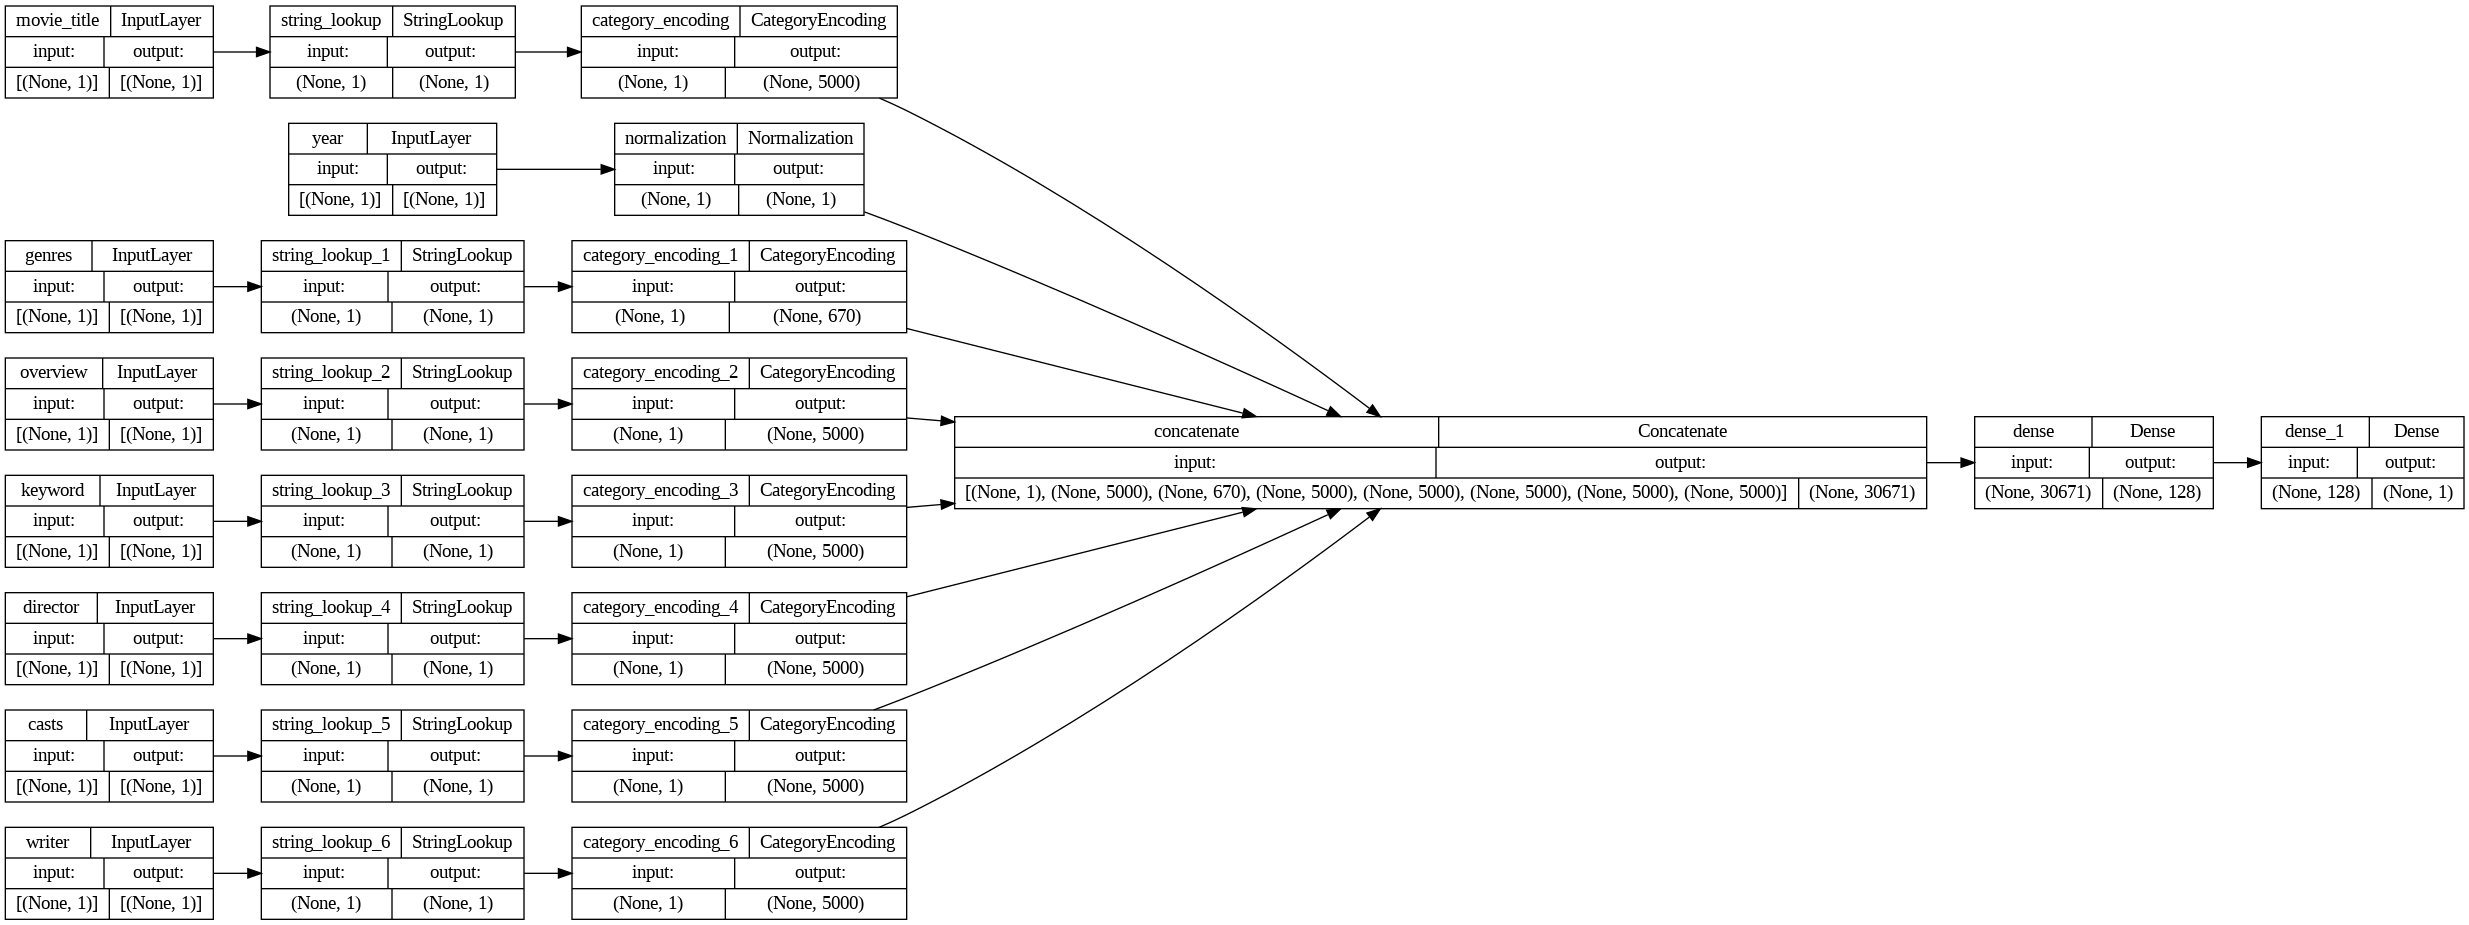

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

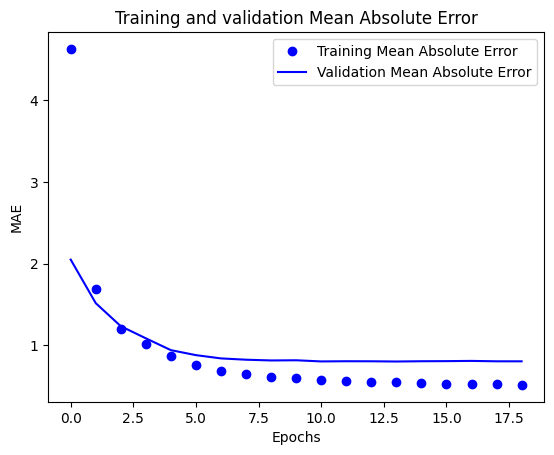

In [ ]:
def plot_loss_acc(history):
    loss = history.history['loss']
    mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mae = history.history['val_mae']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'bo', label='Training Mean Absolute Error')
    plt.plot(epochs, val_mae, 'b', label='Validation Mean Absolute Error')
    plt.title('Training and validation Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

plot_loss_acc(history)

In [ ]:
model_path = 'saved_model'

#model.save(model_path)
model.save(model_path)
reloaded_model = tf.keras.models.load_model(model_path)

loss, accuracy = reloaded_model.evaluate(test_ds)
print("mae", accuracy)
print("loss", loss)

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['rating'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


9/9 [==============================] - 1s 35ms/step - loss: 0.8037 - mae: 0.8037
mae 0.8037455677986145
loss 0.8037455677986145


In [ ]:
!zip -r /content/model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 32%)
  adding: content/saved_model/variables/variables.index (deflated 64%)
  adding: content/saved_model/keras_metadata.pb (deflated 93%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 67%)


In [ ]:
tf.__version__

'2.12.0'

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip show keras

Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow
